In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt
from wordcloud import WordCloud
from konlpy.tag import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('./data/한강수_reviews_추천순.csv')

In [3]:
import re

# 특수 문자 제거 함수 수정: '\n'도 제거하도록 업데이트
def clean_special_characters(text):
    return re.sub(r"[^가-힣a-zA-Z0-9\s]", "", text.replace('\n', ' '))

# 새로운 불용어 리스트 정의
stopwords = [
    "을", "를", "이", "가", "은", "는", "에", "의", "으로", "와", "과", "고", "도", "부터", "까지", 
    "에서", "한테", "에게", "도", "만", "마저", "조차", "처럼", "듯이", "하고", "하여", "했으며", 
    "하다", "였다", "되다", "있다", "그리고", "그러나", "하지만", "그러므로", "따라서", "그런데", 
    "또한", "또", "그러면", "아니면", "아주", "매우", "정말", "너무", "아마", "약간", "조금", 
    "대체로", "대부분", "다소", "한", "이미", "현재", "원래", "싶다", "같다", "보다", "이런", 
    "저런", "그런", "어떤", "모든", "각", "이", "그", "저", "와", "우와", "오", "아", "어", 
    "오오", "아아", "오늘", "어제", "내일", "요즘", "최근", "항상", "자주", "가끔", "언제", 
    "종종", "매일", "이번", "다음", "이전", "것", "수", "분", "때문", "같이", "위해", "중", 
    "후", "전", "등등", "그것", "이것", "저것", "여기", "저기", "거기", "그곳", "이곳", "저쪽",
    "곧", "잠시", "금방", "바로", "지금", "당장", "방금", "아직", "언젠가", "절대", "전혀", 
    "어쩌면", "결국", "종종", "이다", "아니다", "있다", "없다", "위해", "때", "경우", "듯", 
    "게", "걸", "며", "니", "듯", "탓", "만큼", "따름"
]

# 불용어 제거 함수 정의
def remove_stopwords(text):
    # 텍스트를 공백을 기준으로 나눈 후, stopwords에 포함되지 않은 단어들만 다시 결합
    return ' '.join([word for word in text.split() if word not in stopwords])

# 특수 문자 제거 적용
data['Cleaned_Review'] = data['Review'].apply(clean_special_characters)

# 불용어 제거 적용
data['No_Stopwords_Review'] = data['Cleaned_Review'].apply(remove_stopwords)

# 결과 확인
print(data[['Cleaned_Review', 'No_Stopwords_Review']].head())


                                      Cleaned_Review  \
0         동네 친구들이랑 한잔하러 왔어요 주차하기 편하고 고기 질 좋고 가성비 좋아요   
1  강남 뱅뱅매장 뒤편에 위치해있습미당 고기집으로 퀄리티가 좋고 맛도 좋아용 점심메뉴 ...   
2               모두 친철하시고 고기질 뿐만 아니라 반찬하나하나까지 너무 맛있어요   
3                                                  굿   
4                                                  굿   

                                 No_Stopwords_Review  
0         동네 친구들이랑 한잔하러 왔어요 주차하기 편하고 고기 질 좋고 가성비 좋아요  
1  강남 뱅뱅매장 뒤편에 위치해있습미당 고기집으로 퀄리티가 좋고 맛도 좋아용 점심메뉴 ...  
2                  모두 친철하시고 고기질 뿐만 아니라 반찬하나하나까지 맛있어요  
3                                                  굿  
4                                                  굿  


In [ ]:
data

In [ ]:
from gensim.models import Word2Vec

# 리뷰 데이터를 문장 리스트로 변환
# 각 리뷰를 토큰화하여 Word2Vec 입력 형식으로 변환
sentences = [review.split() for review in data['No_Stopwords_Review']]

# Word2Vec 모델 학습
# 파라미터 설명:
# - vector_size: 각 단어 벡터의 차원 수 (보통 100~300 사용)
# - window: 컨텍스트 윈도우 크기, 주변 몇 개의 단어를 고려할지 설정
# - min_count: 최소 등장 횟수가 min_count 미만인 단어는 무시
# - workers: 사용할 CPU 스레드 수 (병렬 처리)
model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# 학습된 모델에서 단어 벡터를 확인하는 예시
# 예: "맛있다"와 유사한 단어들 출력
similar_words = model.wv.most_similar("맛있다", topn=10)
print(similar_words)


In [10]:
from gensim.models import Word2Vec
from itertools import combinations
import pandas as pd

# 리뷰 데이터를 문장 리스트로 변환
sentences = [review.split() for review in data['No_Stopwords_Review']]

# Word2Vec 모델 학습
model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Word2Vec 모델 학습 후 모든 단어 벡터 추출
vocab = list(model.wv.key_to_index)  # 모델에 있는 모든 단어 목록

# 유사 단어 쌍 추출
similar_pairs = []
for word1, word2 in combinations(vocab, 2):
    similarity = model.wv.similarity(word1, word2)
    similar_pairs.append((word1, word2, similarity))

# 유사도가 높은 순으로 상위 50개 단어 쌍 추출
similar_pairs = sorted(similar_pairs, key=lambda x: x[2], reverse=True)[:50]
similar_pairs_df = pd.DataFrame(similar_pairs, columns=["Word1", "Word2", "Similarity"])

# 결과 출력
print(similar_pairs_df)


    Word1   Word2  Similarity
0      굿굿      반찬    0.369629
1     맛나요     고기도    0.348949
2       질       갈    0.339319
3     가성비       다    0.324270
4       안      반찬    0.314797
5       안    영양탕굿    0.311374
6     맛나요   사장님께서    0.303963
7      모두      기분    0.285230
8     맛있고      반찬    0.280219
9      기분      있는    0.271495
10     고기      김치    0.269101
11    고기도       질    0.265470
12  육회비빔밥     갔는데    0.261639
13     기분    점심메뉴    0.260060
14    손님이    점심메뉴    0.259848
15   친절하고      반찬    0.257460
16    사장님      반찬    0.256287
17     기분      직접    0.253900
18    좋아요      진짜    0.252624
19  맛있습니다     고기를    0.249061
20  육회비빔밥      점심    0.248426
21    맛나요      주문    0.248362
22  친절하시고    가져가서    0.248319
23    맛있게     고기도    0.247415
24    있는게     없어서    0.241177
25     모두   좋았습니다    0.239837
26    가성비  괜찮았습니다    0.239412
27    맛있게    밑반찬도    0.237985
28  나올때까지     있는게    0.237120
29   영양탕굿    육사시미    0.233578
30   먹었는데    훌륭하고    0.233231
31    고기도      주문    0.228951
32     진짜 

- "굿굿" - "반찬": 굿굿과 반찬이 유사도 0.369로 함께 언급된 비율이 높다는 것은, 리뷰에서 반찬이 매우 긍정적으로 언급될 때 주로 굿굿이라는 표현과 함께 사용되었을 가능성이 큽니다.

- "가성비" - "다": 가성비와 다가 자주 나타나는 것을 보면, 리뷰에서 "가성비가 좋다", "가성비가 다 괜찮다" 등과 같은 문장이 반복적으로 나왔을 수 있습니다.

- "육회비빔밥" - "갔는데": 특정 음식과 갔는데가 자주 언급되는 것을 보면, 특정한 메뉴를 먹기 위해 방문했다는 맥락이 리뷰에 많이 담겼음을 보여줍니다.

- "맛있게" - "고기도": 맛있게와 고기도가 함께 자주 나타나므로, 리뷰에서 "고기도 맛있게 잘 먹었다"는 평가가 많았음을 의미합니다.

- "가성비" - "괜찮았습니다": 가성비와 괜찮았습니다가 유사하게 자주 사용된 것은 가성비가 좋다는 평가가 많은 리뷰의 공통적인 특징임을 시사합니다.

In [11]:
# 긍정과 부정 단어 리스트 정의 (필요 시 확장 가능)
positive_words = ["좋다", "좋고", "훌륭", "최고", "맛있", "추천", "즐겁", "기쁘", "만족", "감동", "깨끗", "재밌", "친절",
    "감사", "좋아하", "편안", "행복", "깔끔", "존맛", "JMT", "맛집", "짱", "베스트", "대박",
    "최애", "힐링", "감탄", "인생", "역대급", "완벽", "신선", "든든", "엄지 척", "배려", "뿌듯",
    "포근", "추천템", "안심", "만족도 최고", "편리", "세련", "유용", "아늑", "기대 이상", "고급지다",
    "센스있", "특별", "화려", "러블리", "맛보장", "행운", "예쁘다", "베리 굿", "가성비 좋", "적극 추천",
    "감성적", "취향저격", "레전드", "완소", "쏘 스윗", "찐행복", "갓성비", "귀엽", "최애템", "핵꿀잼",
    "고급미", "갓벽", "미쳤다", "오져", "대만족", "찐사랑", "신박", "고퀄", "강추", "존좋", "너무 좋",
    "죽인다", "굿굿", "금손", "소확행", "최상급", "훈훈", "신세계", "고급짐", "재구매 의사", "초강추",
    "귀엽고 예쁨", "찐템", "꿀템", "신박하다", "행복함", "안심됨", "극호", "꾸안꾸", "손맛 좋",
    "핵감동", "친근감", "든든함", "사랑스러움", "행복사", "찐최애", "만점템", "찐인생템", "눈호강",
    "청정구역", "맑고 깨끗", "깨알재미", "귀염", "사랑스럽다", "가성비템", "깔쌈", "베리굿", "딱 좋음",
    "잘 나감", "편의성 굿", "안정적", "배부름", "센스 만점", "짱짱맨", "적극적", "말해 뭐해", "넘사벽",
    "신뢰감", "꿀잼보장", "심쿵", "센스 넘침", "재미짐", "편리함", "만족스러움", "무한 감동", "탄탄함",
    "우수함", "굿", "존맛탱구리", "ㄴㅇㅅ", "내돈내산", "또방문", "재방문 의사 있", "유명", "소문낼",
    "유명한 이유가 있", "돈 값을 하는", "충족", "ㄱㅇㄷ", "개이득", "최상", "킹왕짱", "행복함",
    "맛집 인정", "찐맛", "호불호 없음", "득템각", "부담없", "소장각", "갓템", "마음에 쏙", "신뢰성",
    "마음에 든다", "완소템", "힐링템", "푹신함", "대존맛", "신의 한 수", "필수템", "사길 잘함", "극찬",
    "알차다", "취향존중", "무조건 추천", "고급", "실속 있음", "잘 맞음", "너무 예쁘다",
    "만족함", "매력있음", "비교불가", "퀄리티 갑", "최상의 선택", "역시 좋다", "손이 가요",
    "가치 있음", "핫플", "핵추천", "혜자템", "품질보장", "끝내줌", "강력 추천", "금방 동남",
    "엄지척", "거의 완벽", "찬사받음", "너무 예쁨", "감동적", "눈이 즐거움", "존맛", "핫템",
    "정말 좋아요", "불만 없음", "깔끔한 마무리", "퀄리티 짱", "세상 최고", "매력적", "끝내줌", "눈물남",
    "현존 최고", "좋은 선택", "짱짱", "상상초월", "미친 가성비", "저렴한데 좋음", "찐", "돈 값함",
    "인정", "핵만족", "보장된 품질", "칭찬할 만함", "행운템", "아기자기함", "다시 가고 싶음",
    "핵감사", "짱짱짱", "여긴 진짜다"]
negative_words = ["나쁘", "별로", "싫", "최악", "불편", "문제", "실망", "불만", "안좋", "안되", "부족", "힘들",
    "비싸", "짜증", "불친절", "후회", "아쉽", "형편없", "엉망", "답답", "지루", "불쾌", "피곤",
    "귀찮", "못하", "어렵", "복잡", "짜증나", "실수", "기대 이하", "아깝", "화나", "무례", "미흡",
    "고통", "시끄럽", "안타깝", "낡", "지저분", "아프", "헛걸음", "속상", "똥손", "후지", "망",
    "버거움", "별로임", "바가지", "낙후", "불량", "헛돈", "극혐", "잦은 오류", "대충", "불쾌한 경험",
    "비추", "별로네", "허접", "노답", "구려", "폐급", "구리다", "짜증 폭발", "돈낭비", "헬", "멘붕",
    "분노", "허접하다", "불편함", "답답함", "현타", "먹튀", "짜증남", "신경쓰임", "헛돈", "개노답",
    "한심", "쌩돈", "쓰레기", "이딴", "어설프다", "오류 많음", "형편없음", "허무함", "낭비", "아쉬움",
    "개판", "헬게이트", "어이없음", "대실망", "구림", "후회막급", "서비스 엉망", "좌절", "불편하다",
    "무리수", "취소각", "짜증만땅", "불만족", "더럽다", "화가남", "찝찝", "바가지", "속터짐", "별로다",
    "실망스러움", "별로에요", "스트레스", "무책임", "노잼", "먹금", "못난", "오바임", "과대광고",
    "구라", "실망임", "불만족스럽", "개노답", "망했", "못하겠", "허접쓰", "오지랖", "지저분함",
    "헛소리", "오류투성이", "피곤함", "서비스 엉망진창", "예민함", "낙제점", "답없다", "과함", "잔소리",
    "번거로움", "불완전", "뻘짓", "정떨어짐", "영혼 없음", "허술함", "제자리", "정리안됨", "답이 없음",
    "빈약함", "불친절한 응대", "뻔뻔", "낙후됨", "어이상실", "시간낭비", "멀미", "부실함", "막장임",
    "헛고생", "최악의 경험", "실망감", "엉망진창", "걱정됨", "재방문 의사 없", "개노맛", "실망각",
    "차라리 안 샀음", "먹다 버림", "재구매 없음", "헛돈 날림", "버림", "답답함", "후회함", "개망",
    "터무니없", "형편 없음", "망템", "퀄리티 떨어짐", "돈 아까움", "상태 불량", "비효율적", "쓸모없음",
    "버림", "품질 저하", "오바스러움", "가성비 별로", "마음에 안 듦", "손해", "완전 별로", "무의미",
    "효율성 없음", "가치 없음", "엉성함", "재방문 안함", "비추함", "믿고 걸러", "두 번 다시", "안 맞음",
    "어이없다", "구매 비추천", "완전 구림", "불량품", "기대와 다름", "불쾌감", "미스", "절대 비추",
    "낭비된 돈", "비추요", "이 돈값 못함", "바로 반품", "싼 게 비지떡", "텅텅", "돈값 못함", "손해봤다",
    "별로였음", "너무 별로", "비추템", "핵노잼", "돈 아까움", "실망", "안간다", "차라리 딴데", "속았음",
    "후회만 남음", "맘 상함", "믿거템", "한 번 가고 안 감", "사기템", "버림", "쓰레기템", "더러움",
    "터무니 없음", "낚임", "두 번은 안 감", "쓰레기 서비스", "불안함", "서비스 미숙", "당황스러움",
    "너무 느림", "후회만 가득", "갈 이유 없음", "마음 상함", "말도 안 됨", "너무 허접", "없어서 못감",
    "체감상 별로", "기분 상함", "하자 많음", "최악의 결정", "구매 후회", "안습", "저렴한 티", "헛된 시간",
    "망함", "지저분", "두 번 안 감", "손해봄", "싼 맛에 샀는데 후회", "기대보다 별로", "차라리 안 사는 게",
    "기분 상함", "아무것도 아님", "안 사는 게 나음", "갓성비 아님", "여기만 빼고 다 좋음", "진절머리",
    "진저리", "별로다 못해 최악", "위생이 별로"]

# 감성 점수를 계산하는 함수 정의
def calculate_sentiment_score(text):
    positive_count = sum(word in text for word in positive_words)
    negative_count = sum(word in text for word in negative_words)
    return positive_count - negative_count

# 리뷰 데이터에 감성 점수 컬럼 추가
data['Sentiment_Score'] = data['No_Stopwords_Review'].apply(calculate_sentiment_score)

# 감성 점수 확인
print(data[['No_Stopwords_Review', 'Sentiment_Score']].head())


                                 No_Stopwords_Review  Sentiment_Score
0         동네 친구들이랑 한잔하러 왔어요 주차하기 편하고 고기 질 좋고 가성비 좋아요                2
1  강남 뱅뱅매장 뒤편에 위치해있습미당 고기집으로 퀄리티가 좋고 맛도 좋아용 점심메뉴 ...                2
2                  모두 친철하시고 고기질 뿐만 아니라 반찬하나하나까지 맛있어요                1
3                                                  굿                1
4                                                  굿                1


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF 벡터라이저 설정
vectorizer = TfidfVectorizer(max_features=10)  # 주요 토픽 상위 10개 추출
tfidf_matrix = vectorizer.fit_transform(data['No_Stopwords_Review'])

# 상위 토픽 추출
top_words = vectorizer.get_feature_names_out()
print("Top Topics:", top_words)


Top Topics: ['가성비' '고기' '고기가' '굿굿' '맛나요' '맛있고' '맛있어요' '모두' '좋아요' '진짜']


'친절', '점심', '소고기', '밑반찬', '육회', '직원', '직원 친절', '밑반찬 다양', '다양', '육비'

In [16]:
# 주제별 긍정/부정 평가 요약을 저장할 빈 딕셔너리로 선언
topic_summary = {}  

# 분석하고자 하는 주요 키워드 목록을 리스트로 설정
topics = ['친절', '점심', '소고기', '밑반찬', '육회', '직원', '직원 친절', '밑반찬 다양', '다양', '육비']

for topic in topics:  # top_words가 아닌 직접 지정한 topics 리스트 사용
    positive_reviews = data[(data['No_Stopwords_Review'].str.contains(topic)) & (data['Sentiment_Score'] > 0)].shape[0]
    negative_reviews = data[(data['No_Stopwords_Review'].str.contains(topic)) & (data['Sentiment_Score'] < 0)].shape[0]
    topic_summary[topic] = {"Positive": positive_reviews, "Negative": negative_reviews}

# 결과 요약 출력
topic_summary_df = pd.DataFrame(topic_summary).T
print(topic_summary_df)


        Positive  Negative
친절            15         0
점심             6         0
소고기            2         0
밑반찬            2         0
육회             7         0
직원             4         0
직원 친절          0         0
밑반찬 다양         0         0
다양             0         0
육비             1         0


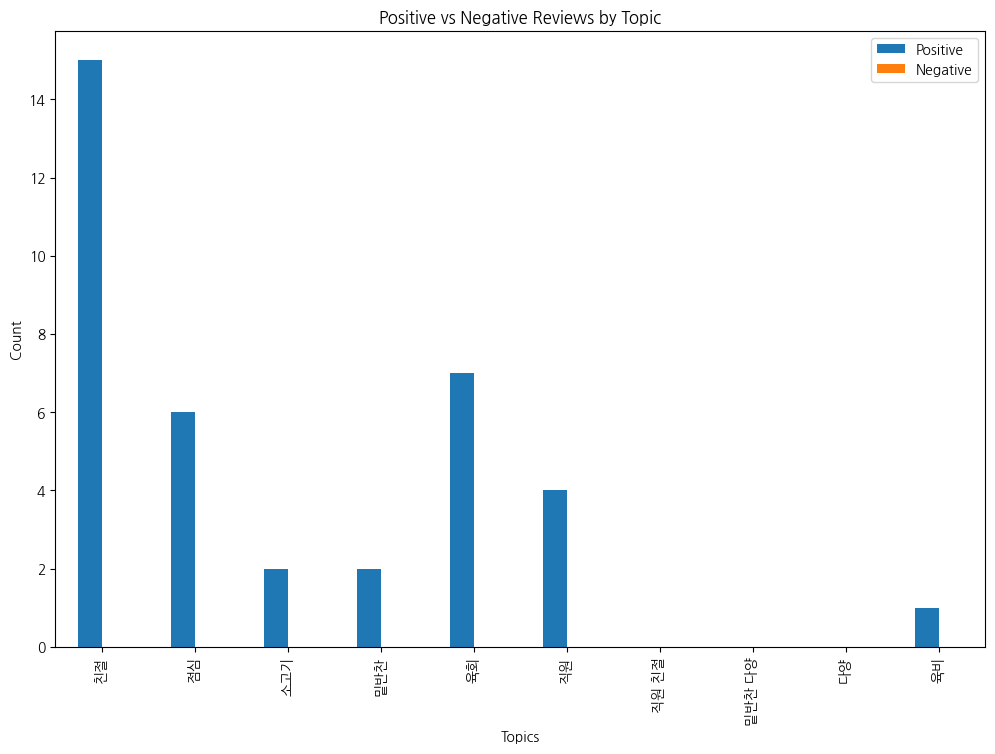

In [18]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 경로 설정 (예: 나눔고딕)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # 시스템에 맞게 폰트 경로 확인
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 그래프에서 마이너스 폰트 깨짐 문제 해결
plt.rcParams['axes.unicode_minus'] = False

# 주제별 긍정/부정 리뷰 개수 시각화
topic_summary_df.plot(kind='bar', figsize=(12, 8))
plt.xlabel("Topics")
plt.ylabel("Count")
plt.title("Positive vs Negative Reviews by Topic")
plt.legend(["Positive", "Negative"])
plt.show()
